In [41]:
import pandas
import numpy
from scipy.signal import iirfilter, lfilter

tick = 25000
window = 128
slide = 0.5


In [42]:
import numpy as np

# signal processing for input batch
fs = 1000000 / tick
filter_N = 4
filter_freq = 10

# noice reduction can be performed optimized on all input (but not only on window), no difference in implementation
def reduce_noice(acDf: pandas.DataFrame, gyDf: pandas.DataFrame):
    b, a = iirfilter(filter_N, Wn=filter_freq, fs=fs, btype="low", ftype="butter")

    acX = lfilter(b, a, acDf.x)
    acY = lfilter(b, a, acDf.y)
    acZ = lfilter(b, a, acDf.z)

    gyX = lfilter(b, a, gyDf.x)
    gyY = lfilter(b, a, gyDf.y)
    gyZ = lfilter(b, a, gyDf.z)

    acDf1 = acDf.copy()
    gyDf1 = gyDf.copy()
    
    acDf1["x"] = acX
    acDf1["y"] = acY
    acDf1["z"] = acZ

    gyDf1["x"] = gyX
    gyDf1["y"] = gyY
    gyDf1["z"] = gyZ

    return (acDf1, gyDf1)
    # acil = (acXil**2 + acYil**2 + acZil**2) ** 0.5
    # gyil = (gyXil**2 + gyYil**2 + gyZil**2) ** 0.5


# compute magnitude on all axis, apply fast fft transformation, 
# get 32 elements of each (accelerometer, gyroscope), max acceleromet, max gyroscope
def extract_features(acDf: pandas.DataFrame, gyDf: pandas.DataFrame, gpsDf: pandas.Series):
    acM = (acDf["x"] ** 2 + acDf["y"] ** 2 + acDf["z"] ** 2) ** 0.5
    gyM = (gyDf["x"] ** 2 + gyDf["y"] ** 2 + gyDf["z"] ** 2) ** 0.5
    maxAc = max(acM)
    maxGy = max(gyM)

    acFft = np.fft.fft(acM)
    gyFft = np.fft.fft(gyM)
    # frequencies = np.fft.fftfreq(window, 1/fs)
    maxFB = int(window * filter_freq / fs)
    
    arrays = (np.abs(acFft[:maxFB]), np.abs(gyFft[:maxFB]), [maxAc, maxGy])
    features = np.concatenate(arrays)
    return features



In [43]:
# reduce noice, extract features (with fft), write
import matplotlib.pyplot as plt
import pandas as pd
import os
import json

raw_dir = "data/pvs-points/raw"
output_dir = "data/pvs-xgboost"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)


entry_fpaths = [os.path.join(raw_dir, x) for x in os.listdir(raw_dir)]
out_file = os.path.join(output_dir, "features-predictions.csv")

def read_entry(entry_fpath):
  with open(entry_fpath) as file:
      data = json.load(file)
      acDf = pd.DataFrame.from_records(data["accelerometer"])
      gyDf = pd.DataFrame.from_records(data["gyroscope"])
      gpsDf = pd.Series(data["gps"])
      prediction = data["prediction"]
      return (acDf, gyDf, gpsDf, prediction)

def display_sensors(acDf, gyDf):
  plt.figure().set_figwidth(20)
  plt.plot(range(0, len(acDf)), acDf["x"].to_numpy(), '-', label="AC")
  plt.plot(range(0, len(gyDf)), gyDf["x"].to_numpy(), '-', label="GY")

def display_features(features):
  plt.figure().set_figwidth(20)
  plt.plot(range(0, len(features)), features)

features_predictions = []

for entry_fpath in entry_fpaths:
    acDf, gyDf, gpsDf, prediction = read_entry(entry_fpath)
    acDfn, gyDfn = reduce_noice(acDf, gyDf)
    features = extract_features(acDf, gyDf, gpsDf)
    features_predictions.append([*features, prediction])
    # if prediction == 0.5:
    #   display_sensors(acDfn, gyDfn)
    #   display_features(features)
    #   print(features)
    #   break
    
features_cnt = len(features_predictions[0])
features_prediction_df_columns = [str(i) for i in range(0, features_cnt - 1)] + ["prediction"]
features_prediction_df = pd.DataFrame(features_predictions, columns=features_prediction_df_columns)
features_prediction_df.to_csv(out_file, index=False)

In [50]:
# select only featues with least correlation
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

features_prediction_df = pd.read_csv(out_file)
print(features_prediction_df)

corr_matrix = features_prediction_df.corr()
corr_with_prediction = corr_matrix['prediction']


correlations = corr_with_prediction.abs().sort_values(ascending=False)
print(correlations)

# select only top k features
k = 24
selected_feature_indexes = correlations[1:k+1].index

out_features_predictions_selected_fpath = os.path.join(output_dir, f"selected-features-predictions-{k}-nospeed.csv")
features_prediction_df_selected = features_prediction_df[[*selected_feature_indexes, 'prediction']]
features_prediction_df_selected.to_csv(out_features_predictions_selected_fpath, index=False)

with open(os.path.join("model", f"selected-features-{k}-nospeed.json"), "w") as file:
  json.dump(list(map(int, selected_feature_indexes)), file)


                0          1          2          3         4         5  \
0       45.506612   0.184853   0.156532   0.238187  0.221436  0.066367   
1       45.785693   0.094247   0.076359   0.278855  0.152617  0.177386   
2       46.058224   0.210844   0.253886   0.187719  0.293883  0.203900   
3       45.873201   0.174223   0.405088   0.259791  0.226499  0.287193   
4       45.619903   0.189425   0.242185   0.184985  0.316593  0.064940   
...           ...        ...        ...        ...       ...       ...   
13317  256.721203  32.360964   4.914833  13.379519  5.247044  4.822437   
13318  181.713566  37.781036  12.765578   4.055747  9.318195  7.572127   
13319  137.600659   2.325365   4.570501   6.375219  0.440890  3.976690   
13320  141.264184   2.578813   6.131641   5.027611  8.458596  5.066336   
13321  106.289947  22.126149   4.275762  12.428787  7.044947  9.356484   

              6         7         8         9  ...        57        58  \
0      0.271164  0.443644  0.399920  

In [51]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

data = pd.read_csv(out_features_predictions_selected_fpath)

reg = xgb.XGBRegressor()

data_shuffled = features_prediction_df_selected.sample(frac=1)

X = data_shuffled.drop(['prediction'], axis=1)
y = data_shuffled['prediction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

reg = reg.fit(X_train.values, y_train)



In [52]:
import pickle

model_dir = "model"

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

with open(os.path.join(model_dir, f"xgboost-features-{k}-nospeed.pickle"), "wb") as file:    pickle.dump(reg, file)

In [53]:
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

def regression_results(y_pred, y_true):
    # Regression metrics
    r2=metrics.r2_score(y_true, y_pred)
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    mse=metrics.mean_squared_error(y_true, y_pred) 

    print('R2: ', round(r2,4)) 
    print('Explained variance (biased): ', round(explained_variance,4)) # if mean(error)=0, then R2 = explained variance score
    print('MSE: ', round(mse,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('RMSE: ', round(np.sqrt(mse),4))

def visualize_sorted_results(y_pred: numpy.array, y_true: numpy.array):
    y_true_ids = y_true.argsort()
    y_true_sorted = y_true[y_true_ids[::-1]]
    y_pred_sorted = y_pred[y_true_ids[::-1]]
    l = len(y_true_sorted)

    plt.figure().set_figwidth(20)
    plt.scatter(range(0, l), y_true_sorted, label="True", s=5)
    plt.scatter(range(0, l), y_pred_sorted, label="Predicted", s=1)

def distribution_results(y_pred: numpy.array, y_true: numpy.array):
    step = 0.1
    y_max = max(y_pred.max(), y_true.max())
    total = int((y_max + step) / step)
    for i in range(0, total):
        lower_bound = i * step
        upper_bound = (i + 1) * step
        y_true_mask = (y_true >= lower_bound) & (y_true < upper_bound)
        y_pred_dist = [0] * total
        for j in range(0, len(y_true)):
            if y_true_mask[j] == False:
                continue
            bucket = int((y_pred[j] - 0.001) / step)
            y_pred_dist[bucket] += 1

        cnt = y_true_mask.sum()
        if cnt != 0:
            rounded_distribution = [round(v/cnt, 3) for v in y_pred_dist]
            print(f"[{round(lower_bound,2)}...{round(upper_bound, 2)}]={cnt}:\t{'/'.join(map(str, rounded_distribution))}")


R2:  0.708
Explained variance (biased):  0.7081
MSE:  0.0389
MAE:  0.1318
RMSE:  0.1972
[0.0...0.1]=646:	0.05/0.098/0.24/0.33/0.207/0.059/0.006/0.002/0.005/0.005/0.0
[0.1...0.2]=54:	0.019/0.019/0.185/0.444/0.259/0.074/0.0/0.0/0.0/0.0/0.0
[0.2...0.3]=39:	0.026/0.128/0.154/0.308/0.308/0.077/0.0/0.0/0.0/0.0/0.0
[0.3...0.4]=63:	0.016/0.016/0.19/0.381/0.254/0.079/0.032/0.016/0.016/0.0/0.0
[0.4...0.5]=52:	0.019/0.038/0.154/0.442/0.25/0.077/0.019/0.0/0.0/0.0/0.0
[0.5...0.6]=1419:	0.011/0.039/0.16/0.35/0.288/0.08/0.022/0.023/0.007/0.021/0.0
[0.6...0.7]=17:	0.0/0.0/0.0/0.059/0.176/0.059/0.059/0.118/0.059/0.471/0.0
[0.7...0.8]=10:	0.0/0.0/0.1/0.2/0.2/0.0/0.0/0.0/0.0/0.5/0.0
[0.8...0.9]=13:	0.0/0.0/0.0/0.0/0.154/0.077/0.231/0.0/0.231/0.308/0.0
[0.9...1.0]=10:	0.0/0.0/0.0/0.0/0.1/0.2/0.1/0.1/0.2/0.3/0.0
[1.0...1.1]=1674:	0.0/0.0/0.001/0.004/0.011/0.006/0.013/0.026/0.056/0.884/0.0


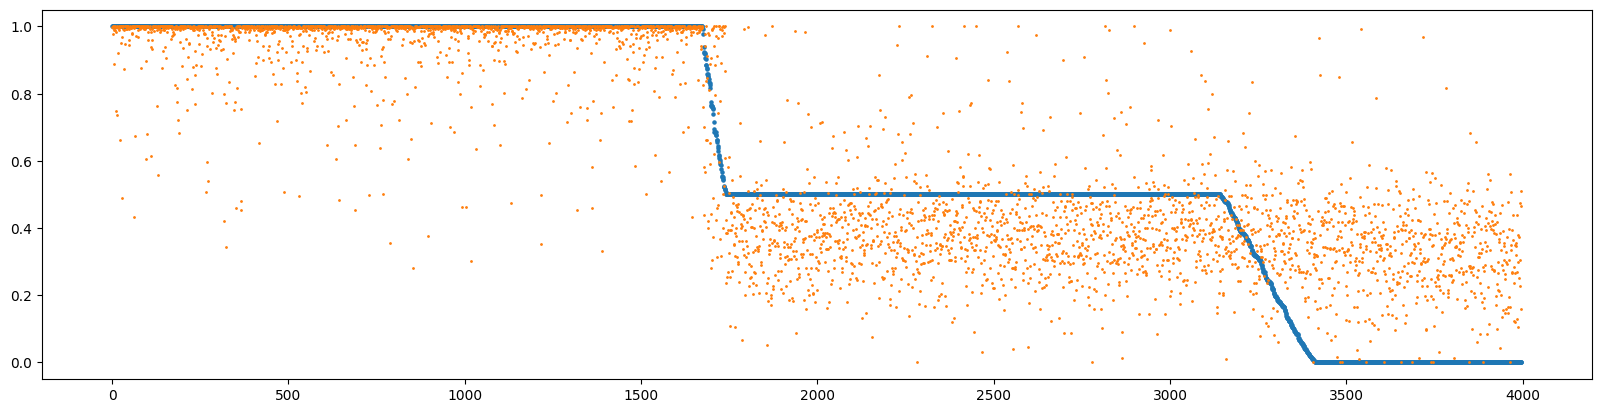

In [54]:
with open(os.path.join(model_dir, f"xgboost-features-{k}-nospeed.pickle"), "rb") as file:
  reg = pickle.load(file)
  y_predicted = reg.predict(X_test.values)
  y_predicted[y_predicted < 0] = 0
  y_predicted[y_predicted > 1] = 1

  regression_results(y_predicted, y_test.to_numpy())
  visualize_sorted_results(y_predicted, y_test.to_numpy())
  distribution_results(y_predicted, y_test.to_numpy())